CS4001/4042 Assignment 1
---
Part A, Q1 (15 marks)
---

>Design a feedforward deep neural network (DNN) which consists of **three** hidden layers of 128 neurons each with ReLU activation function, and an output layer with sigmoid activation function. Apply dropout of probability **0.2** to each of the hidden layers. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import time
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

Define the model class.

In [2]:
class MLP(nn.Module):
# TODO: Enter your code here
    def __init__(self, input_size, hidden_size):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

> Divide the dataset into a 70:30 ratio for training and testing. Use **appropriate** scaling of input features. We solely assume that there are only two datasets here: training & test.

Split the dataset and do preprocessing. You can use the split_dataset and preprocess_dataset provided for you.

In [3]:
from common_utils import split_dataset, preprocess_dataset
# TODO: Enter your code here
df = pd.read_csv("audio_gtzan.csv")
df['label'] = df['filename'].apply(lambda x: x.split('.')[0])

# Drop non-feature columns
columns_to_drop = ['filename', 'label']

# Split dataset (70:30)
X_train, y_train, X_test, y_test = split_dataset(df, columns_to_drop, 0.3, 42)
X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)

# print(X_train.head())
# Note that 0 is for blues, 1 is for metal

> Use the training dataset to train the model for 100 epochs. Use a mini-batch gradient descent with **‘Adam’** optimizer with learning rate of **0.001**, and **batch size = 128**. Implement early stopping with patience of **3**.

1. Define a Pytorch Dataset and Dataloaders.  

In [4]:
# TODO: Enter your code here
# Define Pytorch Dataset
class AudioDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(-1)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create data loaders
train_dataset = AudioDataset(X_train_scaled, y_train)
test_dataset = AudioDataset(X_test_scaled, y_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

2. Next, define the model, optimizer and loss function.

In [5]:
# TODO: Enter your code here
# print(X_train.columns)
input_dim = len(list(X_train.head()))
model = MLP(input_dim, 128)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

3. Train model for 100 epochs. Record down train and test accuracies. Implement early stopping.

In [6]:
from common_utils import EarlyStopper

# TODO: Enter your code here
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    train_loss = 0.0
    correct = 0

    for batch_features, batch_labels in dataloader:
        # Forward pass
        predictions = model(batch_features)
        loss = loss_fn(predictions, batch_labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        train_loss += loss.item() * batch_features.size(0)

        # Computer Accuracy
        predicted_labels = predictions.round()
        correct += predicted_labels.eq(batch_labels).sum().item()

    avg_loss = train_loss / size
    accuracy = correct / size * 100
    return avg_loss, accuracy


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0.0
    correct = 0

    with torch.no_grad():
        for batch_features, batch_labels in dataloader:
            # Forward pass
            predictions = model(batch_features)
            loss = loss_fn(predictions, batch_labels)
            test_loss += loss.item() * batch_features.size(0)

            # Compute accuracy
            predicted_labels = predictions.round()
            correct += predicted_labels.eq(batch_labels).sum().item()

    avg_loss = test_loss / size
    accuracy = correct / size * 100
    return avg_loss, accuracy



# Early stopping
early_stopper = EarlyStopper(patience=3, min_delta=0)

# Training parameters
epochs = 100
train_losses, train_accuracies, test_losses, test_accuracies = [], [], [], []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    # Train for one epoch
    train_loss, train_accuracy = train_loop(train_loader, model, loss_fn, optimizer)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluate on the test set
    test_loss, test_accuracy = test_loop(test_loader, model, loss_fn)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    # Print progress
    print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    # Early stopping check
    if early_stopper.early_stop(test_loss):
        print("Early stopping triggered.")
        break

print("Training complete.")

Epoch 1/100
Train Loss: 0.6098, Test Loss: 0.4780, Test Accuracy: 82.00%
Epoch 2/100
Train Loss: 0.3744, Test Loss: 0.3247, Test Accuracy: 87.33%
Epoch 3/100
Train Loss: 0.2580, Test Loss: 0.2393, Test Accuracy: 90.33%
Epoch 4/100
Train Loss: 0.1772, Test Loss: 0.2007, Test Accuracy: 92.00%
Epoch 5/100
Train Loss: 0.1270, Test Loss: 0.1908, Test Accuracy: 93.17%
Epoch 6/100
Train Loss: 0.0948, Test Loss: 0.1593, Test Accuracy: 94.00%
Epoch 7/100
Train Loss: 0.0781, Test Loss: 0.1422, Test Accuracy: 94.83%
Epoch 8/100
Train Loss: 0.0603, Test Loss: 0.1355, Test Accuracy: 95.33%
Epoch 9/100
Train Loss: 0.0492, Test Loss: 0.1203, Test Accuracy: 95.67%
Epoch 10/100
Train Loss: 0.0483, Test Loss: 0.1330, Test Accuracy: 96.00%
Epoch 11/100
Train Loss: 0.0373, Test Loss: 0.1159, Test Accuracy: 96.17%
Epoch 12/100
Train Loss: 0.0262, Test Loss: 0.1156, Test Accuracy: 96.50%
Epoch 13/100
Train Loss: 0.0223, Test Loss: 0.1097, Test Accuracy: 96.83%
Epoch 14/100
Train Loss: 0.0254, Test Loss: 0.1

> Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots.

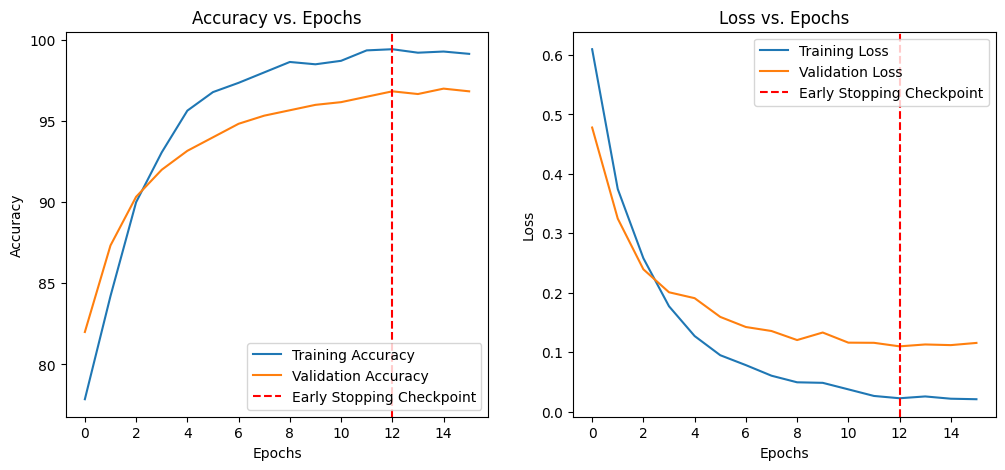

In [7]:
# TODO: Enter your code here
plt.figure(figsize=(12, 5))

# Plot accuracy on the left (subplot 1)
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(test_accuracies, label="Validation Accuracy")
minposs = test_losses.index(min(test_losses)) + 1  # Epoch where early stopping occurred
plt.axvline(minposs - 1, linestyle='--', color='r', label='Early Stopping Checkpoint')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Epochs")
plt.legend()

# Plot losses on the right (subplot 2)
plt.subplot(1, 2, 2)
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
minposs = test_losses.index(min(test_losses)) + 1
plt.axvline(minposs - 1, linestyle='--', color='r', label='Early Stopping Checkpoint')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs. Epochs")
plt.legend()

plt.show()

\# TODO: \
The model achieves a high training and testing accuracy, indicating good performance on both training and testing dataset.\
The early stopping mechanism helped prevent further overfitting by halting training when the test loss stops improving significantly, around Epoch 12 instead of continuing till 100 Epochs.


Part A, Q2 (10 marks)
---

In this question, we will determine the optimal batch size for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient descent by training the neural network and evaluating the performances for different batch sizes. Note: Use 5-fold cross-validation on training partition to perform hyperparameter selection. You will have to reconsider the scaling of the dataset during the 5-fold cross validation.

To reduce repeated code, you may need to place the network (MLP defined in QA1) in a separate file called **common_utils.py**. Import it here for Q2. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

In [8]:
# TODO: Enter your code here
from common_utils import MLP

> Plot mean cross-validation accuracies on the final epoch for different batch sizes as a scatter plot. Limit search space to batch sizes {32, 64, 128, 256}. Next, create a table of time taken to train the network on the last epoch against different batch sizes. Finally, select the optimal batch size and state a reason for your selection. This might take a while to run, so plan your time carefully.

1. Define different folds for different batch sizes to get a dictionary of training and validation datasets. Preprocess your datasets accordingly. Please use the following name conventions:
    - X_train_scaled_dict[batch_size] is a list of the preprocessed training matrix for the different folds. 
    - X_val_scaled_dict[batch_size] is a list of the processed validation matrix for the different folds. 
    - y_train_dict[batch_size] and y_val_dict[batch_size] is a list of labels for the different folds.

In [9]:
# TODO: Enter your code here
X_train_scaled_dict = {}
X_val_scaled_dict = {}
y_train_dict = {}
y_val_dict = {}


def prepare_folds(X, Y, batch_sizes, no_folds=5):
    kf = KFold(n_splits=no_folds, shuffle=True, random_state=42)

    for batch_size in batch_sizes:
        X_train_scaled_dict[batch_size] = []
        X_val_scaled_dict[batch_size] = []
        y_train_dict[batch_size] = []
        y_val_dict[batch_size] = []

        for train_idx, val_idx in kf.split(X):
            scaler = preprocessing.StandardScaler()
            X_train_scaled = scaler.fit_transform(X[train_idx])
            X_val_scaled = scaler.transform(X[val_idx])

            X_train_scaled_dict[batch_size].append(X_train_scaled)
            X_val_scaled_dict[batch_size].append(X_val_scaled)
            y_train_dict[batch_size].append(Y[train_idx])
            y_val_dict[batch_size].append(Y[val_idx])


# Convert DataFrame to NumPy arrays
df = df.drop('filename', axis=1)
Y = df['label'].to_numpy()
X = df.drop('label', axis=1).to_numpy()

batch_sizes = [32, 64, 128, 256]
prepare_folds(X, Y, batch_sizes)

2. Perform hyperparameter tuning for the different batch sizes with 5-fold cross validation. 

In [10]:
# TODO: Enter your code here
def train_exp(batch_sizes, no_folds=5, no_epochs=20, lr=0.001):
    results = {}

    for batch_size in batch_sizes:
        accuracies = []
        epoch_times = []

        for fold in range(no_folds):
            # Retrieve preprocessed data
            x_train = X_train_scaled_dict[batch_size][fold]
            y_train = y_train_dict[batch_size][fold]
            x_val = X_val_scaled_dict[batch_size][fold]
            y_val = y_val_dict[batch_size][fold]

            # Convert to tensors
            x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
            y_train_tensor = torch.tensor(
                y_train, dtype=torch.float32).view(-1, 1)
            x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
            y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

            train_loader = torch.utils.data.DataLoader(
                dataset=torch.utils.data.TensorDataset(
                    x_train_tensor, y_train_tensor),
                batch_size=batch_size,
                shuffle=True
            )

            model = MLP(input_size=x_train.shape[1], hidden_size= 128)
            loss_fn = nn.BCELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)

            for epoch in range(no_epochs):
                model.train()
                start_time = time.time()

                for batch_X, batch_y in train_loader:
                    optimizer.zero_grad()
                    outputs = model(batch_X)
                    loss = loss_fn(outputs, batch_y)
                    loss.backward()
                    optimizer.step()

                end_time = time.time()
                last_epoch_time = end_time - start_time

            # Evaluate model
            model.eval()
            with torch.no_grad():
                test_outputs = model(x_val_tensor)
                preds = (test_outputs > 0.5).float()
                accuracy = (preds == y_val_tensor).sum().item() / \
                    len(y_val_tensor)

            accuracies.append(accuracy)
            epoch_times.append(last_epoch_time)

        # Store mean performance
        results[batch_size] = {
            "mean_accuracy": np.mean(accuracies),
            "mean_time": np.mean(epoch_times)
        }

    return results

# Run training experiment
results = train_exp(batch_sizes)

3. Plot scatterplot of mean cross validation accuracies on the final epoch for the different batch sizes. Limit search space to batch sizes {32, 64, 128, 256}.

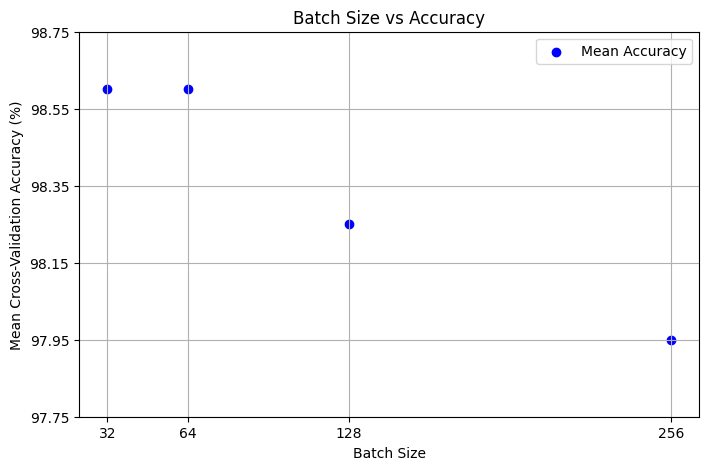

In [11]:
# TODO: Enter your code here
batch_sizes_list = list(results.keys())
mean_accuracies = [results[bs]["mean_accuracy"] * 100 for bs in batch_sizes_list]
mean_times = [results[bs]["mean_time"] for bs in batch_sizes_list]

# Plot acc
plt.figure(figsize=(8, 5))
plt.scatter(batch_sizes_list, mean_accuracies, color='blue', label="Mean Accuracy")

# Format x and y labels
plt.xlabel("Batch Size")
plt.xticks(batch_sizes_list)
plt.ylabel("Mean Cross-Validation Accuracy (%)")
plt.yticks(np.arange(min(mean_accuracies) - 0.2, max(mean_accuracies) + 0.2, 0.2))  # Make even

plt.title("Batch Size vs Accuracy")
plt.grid(True)
plt.legend()
plt.show()

4. Create a table of time taken to train the network on the last epoch against different batch sizes. 

In [12]:
# TODO: Enter your code here
# Print training time table
print("\nTraining Time for Last Epoch:")
print(f"{'Batch Size':<10} {'Mean Time (s)':<15}")
for bs, time_taken in zip(batch_sizes_list, mean_times):
    print(f"{bs:<10} {time_taken:<15.5f}")

optimal_batch_size = batch_sizes_list[np.argmax(mean_accuracies)] # Assume best = highest acc
print(f"\nOptimal batch size: {optimal_batch_size}")


Training Time for Last Epoch:
Batch Size Mean Time (s)  
32         0.10351        
64         0.06122        
128        0.03858        
256        0.02578        

Optimal batch size: 32


5. Select the optimal batch size and state a reason for your selection.

\# TODO:\
The optimal batch size would be 32 in our case, it has one of the highest accuracy despite having the longest Batch Size Mean Time compared to the other batch sizes. Batch size 64 is a good contender but since the batch size is double the training mean time should be half but the performance increase is only about 40%.
Ideally both works, but in theory higher batch size causes overfitting and the time taken was relatively short so having a small batch size was comfortable for this assignment/experiment.\
\
*Note that the value changes whenever this portion is rerun*
> (103-61)/103 = 40%

Part A, Q3 (10 marks)
---
In this question, we will find the optimal number of hidden neurons for first hidden layer of the 4-layer network (3 hidden layers, output layer) designed in Q1 and Q2.

To reduce repeated code, you may need to import the network (MLP defined in QA1) from common_utils.py. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

In [13]:
# TODO: Enter your code here
from common_utils import MLP
# Define dictionary to store datasets for different neuron configurations
X_train_scaled_dict = {}
X_val_scaled_dict = {}
y_train_dict = {}
y_val_dict = {}


def prepare_folds(X, Y, hidden_units, no_folds=5):
    kf = KFold(n_splits=no_folds, shuffle=True, random_state=42)

    for neurons in hidden_units:
        X_train_scaled_dict[neurons] = []
        X_val_scaled_dict[neurons] = []
        y_train_dict[neurons] = []
        y_val_dict[neurons] = []

        for train_idx, val_idx in kf.split(X):
            scaler = preprocessing.StandardScaler()
            X_train_scaled = scaler.fit_transform(X[train_idx])
            X_val_scaled = scaler.transform(X[val_idx])

            X_train_scaled_dict[neurons].append(X_train_scaled)
            X_val_scaled_dict[neurons].append(X_val_scaled)
            y_train_dict[neurons].append(Y[train_idx])
            y_val_dict[neurons].append(Y[val_idx])


# Convert DataFrame to NumPy arrays
label_encoder = preprocessing.LabelEncoder()
df = pd.read_csv("audio_gtzan.csv")
df['label'] = df['filename'].apply(lambda x: x.split('.')[0])
df['label'] = label_encoder.fit_transform(df['label'])
# Drop non-feature columns
Y = df['label'].to_numpy()
df = df.drop('filename', axis=1)
X = df.drop('label', axis=1).to_numpy()

hidden_units = [64, 128, 256]
prepare_folds(X, Y, hidden_units)

> Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}. Continue using 5-fold cross validation on training dataset. 

1. Perform hyperparameter tuning for the different neurons with 5-fold cross validation.

In [14]:
# TODO: Enter your code here
def train_exp(hidden_units, no_folds=5, no_epochs=20, lr=0.001):
    results = {}

    for neurons in hidden_units:
        accuracies = []

        for fold in range(no_folds):
            # Retrieve preprocessed data
            x_train = X_train_scaled_dict[neurons][fold]
            y_train = y_train_dict[neurons][fold]
            x_val = X_val_scaled_dict[neurons][fold]
            y_val = y_val_dict[neurons][fold]

            # Convert to tensors
            x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
            y_train_tensor = torch.tensor(
                y_train, dtype=torch.float32).view(-1, 1)
            x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
            y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

            train_loader = torch.utils.data.DataLoader(
                dataset=torch.utils.data.TensorDataset(
                    x_train_tensor, y_train_tensor),
                batch_size=32,
                shuffle=True
            )

            model = MLP(input_size=x_train.shape[1], hidden_size= neurons)
            loss_fn = nn.BCELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)

            for epoch in range(no_epochs):
                model.train()
                for batch_X, batch_y in train_loader:
                    optimizer.zero_grad()
                    outputs = model(batch_X)
                    loss = loss_fn(outputs, batch_y)
                    loss.backward()
                    optimizer.step()

            # Evaluate model
            model.eval()
            with torch.no_grad():
                test_outputs = model(x_val_tensor)
                preds = (test_outputs > 0.5).float()
                accuracy = (preds == y_val_tensor).sum().item() / \
                    len(y_val_tensor)

            accuracies.append(accuracy)

        # Store mean accuracy
        results[neurons] = np.mean(accuracies)

    return results


# Run experiment for different hidden-layer neurons
results = train_exp(hidden_units)

2. Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}.

C:\Users\Alan Wong\AppData\Local\Temp\ipykernel_35124\1438326185.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


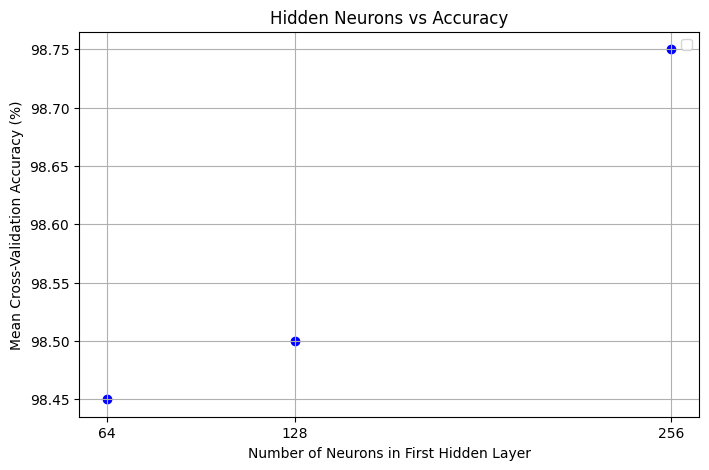

In [15]:
# TODO: Enter your code here
# Extract data for plotting
neuron_list = list(results.keys())
mean_accuracies = [results[n] * 100 for n in neuron_list]

# Plot acc
plt.figure(figsize=(8, 5))
plt.scatter(neuron_list, mean_accuracies, color='blue')

# Format x and y labels
plt.xlabel("Number of Neurons in First Hidden Layer")
plt.xticks(neuron_list)
plt.ylabel("Mean Cross-Validation Accuracy (%)")

plt.title("Hidden Neurons vs Accuracy")
plt.grid(True)
plt.legend()
plt.show()


> Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

In [16]:
# TODO: Enter your code here
# Optimal number of neurons = highest accuracy
optimal_neurons = neuron_list[np.argmax(mean_accuracies)]
print(f"\nOptimal number of neurons: {optimal_neurons}")



Optimal number of neurons: 256


\# TODO: \
A higher number of neurons allows the neural network to learn more intricate patterns and relationships in the data. This is particularly useful for datasets with high complexity or non-linear relationships, especially so for the dataset in this assignment given the nature of music.\
One other factor would be reducing the risk of underfitting. Previously, the batch size was 32 which was to prevent overfitting. Having a larger number of neurons might prevent the opposite of underfitting.

> Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot.
Note: use this optimal number of neurons for the rest of the experiments.

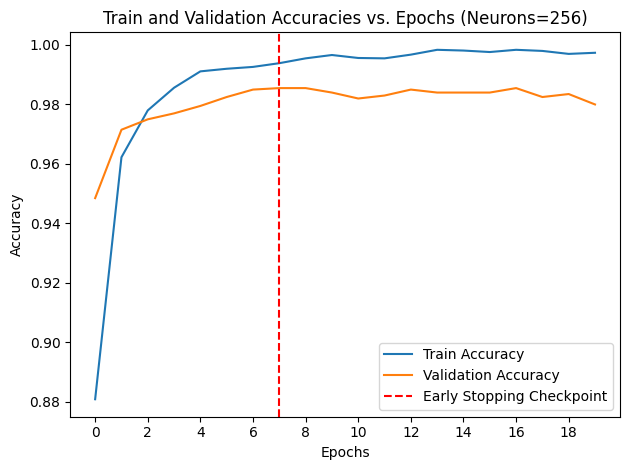

Model saved successfully!


In [17]:
# TODO: Enter your code here
def train_exp(hidden_units, no_folds=5, no_epochs=20, lr=0.001):
    results = {}

    for neurons in hidden_units:
        accuracies = []
        train_accuracies_folds = []
        val_accuracies_folds = []

        for fold in range(no_folds):
            # Retrieve preprocessed data
            x_train = X_train_scaled_dict[neurons][fold]
            y_train = y_train_dict[neurons][fold]
            x_val = X_val_scaled_dict[neurons][fold]
            y_val = y_val_dict[neurons][fold]

            # Convert to tensors
            x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
            y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
            x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
            y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

            train_loader = torch.utils.data.DataLoader(
                dataset=torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor),
                batch_size=32,
                shuffle=True
            )

            model = MLP(input_size=x_train.shape[1], hidden_size=neurons)
            loss_fn = nn.BCELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)

            # Initialize lists to store acc for this fold
            train_accuracies = []
            val_accuracies = []

            # Track acc for every epoch
            for epoch in range(no_epochs):
                model.train()
                correct_train = 0
                total_train = 0
                for batch_X, batch_y in train_loader:
                    optimizer.zero_grad()
                    outputs = model(batch_X)
                    loss = loss_fn(outputs, batch_y)
                    loss.backward()
                    optimizer.step()

                    # Calculate training accuracy
                    preds_train = (outputs > 0.5).float()
                    correct_train += (preds_train == batch_y).sum().item()
                    total_train += len(batch_y)

                train_accuracy = correct_train / total_train
                train_accuracies.append(train_accuracy)

                # Evaluate on validation set
                model.eval()
                with torch.no_grad():
                    val_outputs = model(x_val_tensor)
                    preds_val = (val_outputs > 0.5).float()
                    correct_val = (preds_val == y_val_tensor).sum().item()
                    val_accuracy = correct_val / len(y_val_tensor)
                    val_accuracies.append(val_accuracy)

            # Store acc for each fold
            train_accuracies_folds.append(train_accuracies)
            val_accuracies_folds.append(val_accuracies)

            # Store mean accuracy for this fold
            accuracies.append(np.mean(val_accuracies))

        # Store the average of accuracies for this configuration
        results[neurons] = np.mean(accuracies)

        # Plot the train and test accuracies for this configuration (256 neurons)
        if neurons == 256:
            # Average accuracies across folds for each epoch
            avg_train_accuracies = np.mean(train_accuracies_folds, axis=0)
            avg_val_accuracies = np.mean(val_accuracies_folds, axis=0)
            best_epoch = np.argmax(avg_val_accuracies) + 1 # +1 because epochs start from 1
            plt.plot(avg_train_accuracies, label='Train Accuracy')
            plt.plot(avg_val_accuracies, label='Validation Accuracy')
            plt.axvline(best_epoch - 1, linestyle='--', color='r', label='Early Stopping Checkpoint')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.title(f'Train and Validation Accuracies vs. Epochs (Neurons={neurons})')
            plt.xticks(np.arange(0, no_epochs, 2))
            plt.legend()
            plt.tight_layout()
            plt.show()

    return results

results = train_exp([256]) # Run for optimal number of neurons

print("Model saved successfully!")

Part A, Q4 (10 marks)
---
In this section, we will understand the utility of such a neural network for a test audio. 

Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. 
Find the most important features on the model prediction for the test sample using SHAP. Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5, 
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195) 

To reduce repeated code, you may need to import the network (MLP defined in QA1) from **common_utils.py**. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

In [18]:
# TODO: Enter your code here
from common_utils import MLP
from common_utils import extract_features

df = pd.read_csv("audio_gtzan.csv")
df['label'] = df['filename'].apply(lambda x: x.split('.')[0])
# Drop non-feature columns
columns_to_drop = ['filename', 'label']

# Split dataset (70:30)
X_train, y_train, X_test, y_test = split_dataset(df, columns_to_drop, 0.3, 42)
X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)

# Create training and testing datasets
train_dataset = AudioDataset(X_train_scaled, y_train)
test_dataset = AudioDataset(X_test_scaled, y_test)

# Use batch size of 32
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize values
input_dim = len(list(X_train.head()))
hidden_dim = 256
model = MLP(input_dim, hidden_dim)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

# Early stopping setup
early_stopper = EarlyStopper(patience=3, min_delta=0)

# Training parameters
epochs = 100
train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    # Train for one epoch
    train_loss, train_accuracy = train_loop(train_loader, model, loss_fn, optimizer)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluate on the test set
    test_loss, test_accuracy = test_loop(test_loader, model, loss_fn)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    # Print progress
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")

    # Early stopping check based on validation/test loss
    if early_stopper.early_stop(test_loss):
        print("Early stopping triggered.")
        break

print("Training complete.")

Epoch 1/100
Train Loss: 0.3020, Train Acc: 88.07%, Test Loss: 0.2059, Test Acc: 92.50%
Epoch 2/100
Train Loss: 0.1080, Train Acc: 95.86%, Test Loss: 0.1562, Test Acc: 94.83%
Epoch 3/100
Train Loss: 0.0619, Train Acc: 98.14%, Test Loss: 0.1202, Test Acc: 95.50%
Epoch 4/100
Train Loss: 0.0432, Train Acc: 98.79%, Test Loss: 0.1637, Test Acc: 95.50%
Epoch 5/100
Train Loss: 0.0276, Train Acc: 99.29%, Test Loss: 0.1199, Test Acc: 97.00%
Epoch 6/100
Train Loss: 0.0212, Train Acc: 99.07%, Test Loss: 0.1372, Test Acc: 97.33%
Epoch 7/100
Train Loss: 0.0110, Train Acc: 99.71%, Test Loss: 0.1054, Test Acc: 97.33%
Epoch 8/100
Train Loss: 0.0200, Train Acc: 99.07%, Test Loss: 0.1330, Test Acc: 97.17%
Epoch 9/100
Train Loss: 0.0146, Train Acc: 99.64%, Test Loss: 0.1355, Test Acc: 97.50%
Epoch 10/100
Train Loss: 0.0039, Train Acc: 99.93%, Test Loss: 0.1390, Test Acc: 97.50%
Early stopping triggered.
Training complete.


> Install and import shap

In [19]:
# TODO: Enter your code here
import shap

> Preprocess 'audio_test.wav' using the function 'extract_features' in common_utils.py. Please make sure the features are stored in a pandas dataframe, using variable name 'df', and fill the size of 'df' in 'size_row' and 'size_column'.

In [20]:
import IPython
IPython.display.Audio("./audio_test.wav")

In [21]:
# TODO: Enter your code here
from common_utils import extract_features
df = extract_features(filepath="audio_test.wav")
num_rows, num_columns = df.shape
size_row = num_rows
size_column = num_columns

> Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. 

 1.  Preprocess to obtain the test data, save the test data as numpy array, print the shape of the test data.

In [22]:
# TODO: Enter your code here
test_data = df.drop(columns=["filename"])
print(test_data)
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
feature_set_scaled = scaler.transform(test_data)
print(feature_set_scaled)
feature_names = test_data.columns.tolist()
print(feature_names)

   chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0          0.431877         0.080057  0.056604  0.000293   

   spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0             1191.619716           40957.603068              1726.917471   

   spectral_bandwidth_var  rolloff_mean    rolloff_var  ...  mfcc16_mean  \
0            38831.324373   2794.225223  366570.609513  ...    -3.746181   

   mfcc16_var  mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  \
0   56.647854    -6.391425   37.167595    -2.303412   43.675926    -8.247708   

   mfcc19_var  mfcc20_mean  mfcc20_var  
0   30.502142    -13.78649   46.941544  

[1 rows x 57 columns]
[[ 0.20390526 -0.07506487 -1.40636339 -0.76749685 -1.47853455 -0.90977982
  -1.08496876 -0.59702608 -1.2508248  -0.63718599 -1.41894395 -0.98113232
   0.4949798  -0.96691506  0.91406072 -0.98198501 -1.05586191 -1.53830608
  -0.25927161  1.56394267 -0.63873783  0.75706588 -0.76353323  0.19475427
  -0.5628

2. Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. Note: Please define the variable of your final predicted label as 'pred_label'.

In [23]:
# TODO: Enter your code here
new_row_tensor = torch.tensor(feature_set_scaled, dtype=torch.float32)
model.eval()

with torch.no_grad():
    prediction = model(new_row_tensor)
    pred_label = prediction.round().item()

print(f"Predicted probability: {prediction.item():.4f}")
print(f"Predicted label: {'Blues' if pred_label == 0 else 'Metal'}")
print(pred_label)

Predicted probability: 0.0000
Predicted label: Blues
0.0


> Find the most important features on the model prediction for your test sample using SHAP. Create an instance of the DeepSHAP which is called DeepExplainer using traianing dataset: https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html.

Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5, 
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195) 

shap_values[0]: (57, 1)
feature_set_scaled[0]: (57,)
Feature names: 57
SHAP values shape: 1, (57, 1)


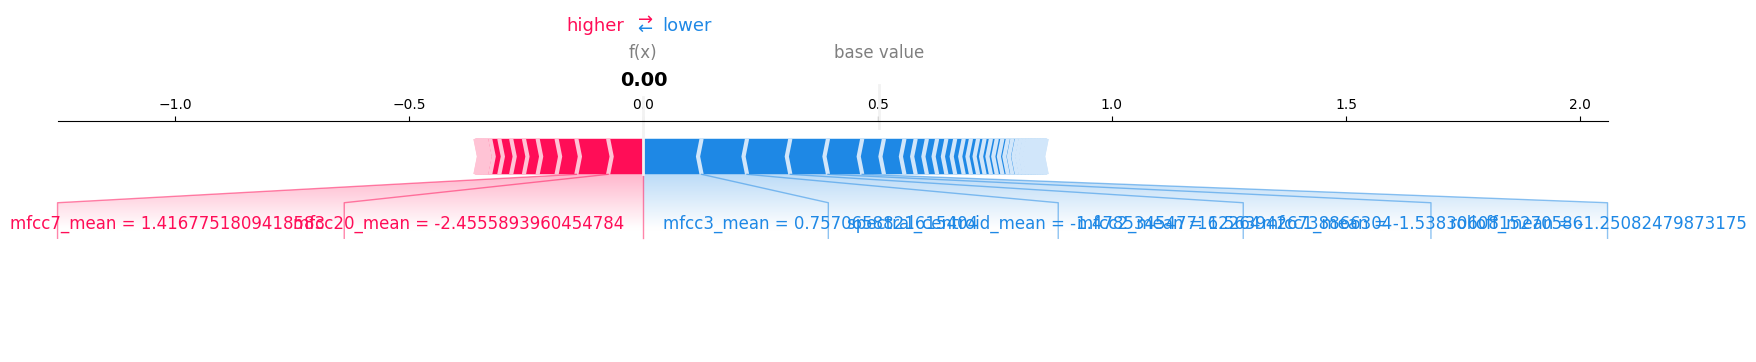

In [25]:
'''
Fit the explainer on a subset of the data (you can try all but then gets slower)
Return approximate SHAP values for the model applied to the data given by X.
Plot the local feature importance with a force plot and explain your observations.
'''
# TODO: Enter your code here
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
background_data = X_train_tensor # Use all

explainer = shap.DeepExplainer(model, background_data)
shap_values = explainer.shap_values(new_row_tensor)
print(f"shap_values[0]: {np.array(shap_values[0]).shape}")
print(f"feature_set_scaled[0]: {feature_set_scaled[0].shape}")
print(f"Feature names: {len(feature_names)}")

print(f"SHAP values shape: {len(shap_values)}, {shap_values[0].shape}")

# Generate force plot for a single test sample
shap.force_plot(
    explainer.expected_value[0],
    shap_values[0].flatten(),
    feature_set_scaled[0],
    feature_names=feature_names,
    matplotlib = True
)



\# TODO: \
A force plot explains a single prediction by showing how each feature contributes positively or negatively to the model's output. \
We are able to see which features had the most significant impact on this specific prediction as well as whether each feature contributed positively or negatively to the prediction. We can also see how close the prediction is to the base value.\
As seen in the image above, some key factors are mfcc20_mean, mfcc3_mean. These 2 are contrasting factors and they are the closest to the base value.
